In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#from tensorflow.keras import layers, models, regularizers
import seaborn as sns


df = pd.read_csv('nba_2022-23_stats.csv')

print(df.head())
print(df.dtypes)
print(df.describe())

   Unnamed: 0        Player Name    Salary Position  Age     Team  GP  GS  \
0           0      Stephen Curry  48070014       PG   34      GSW  56  56   
1           1          John Wall  47345760       PG   32      LAC  34   3   
2           2  Russell Westbrook  47080179       PG   34  LAL/LAC  73  24   
3           3       LeBron James  44474988       PF   38      LAL  55  54   
4           4       Kevin Durant  44119845       PF   34  BRK/PHO  47  47   

     MP    FG  ...  TOV%  USG%  OWS  DWS   WS  WS/48  OBPM  DBPM  BPM  VORP  
0  34.7  10.0  ...  12.5  31.0  5.8  2.0  7.8  0.192   7.5   0.1  7.5   4.7  
1  22.2   4.1  ...  17.1  27.0 -0.4  0.7  0.3  0.020  -0.8  -0.4 -1.2   0.1  
2  29.1   5.9  ...  18.4  27.7 -0.6  2.6  1.9  0.044   0.3  -0.1  0.2   1.2  
3  35.5  11.1  ...  11.6  33.3  3.2  2.4  5.6  0.138   5.5   0.6  6.1   4.0  
4  35.6  10.3  ...  13.4  30.7  4.7  2.1  6.8  0.194   6.0   1.2  7.1   3.9  

[5 rows x 52 columns]
Unnamed: 0         int64
Player Name       obj

Data Cleaning

In [43]:
dfCleaned = df.copy()

From the overview of the dataset we can see 3P is an object type when we expect it to be a float64. Since there is only one row where this seems to be the case we calculate it manually by multiplying 3P% by 3PA.

In [44]:
import numpy as np
import pandas as pd

# non-numeric entries in 3P (values that coerce to NaN but aren’t NaN already)
bad_mask = pd.to_numeric(dfCleaned['3P'], errors='coerce').isna() & dfCleaned['3P'].notna()
bad_idx = dfCleaned.index[bad_mask]
print(f"Non-numeric entries in 3P: {bad_mask.sum()}")

if bad_mask.any():
    print(dfCleaned.loc[bad_idx, ['Player Name', '3P', '3PA', '3P%']].head())

#Reconstruct 3P
has_parts = bad_mask & dfCleaned['3PA'].notna() & dfCleaned['3P%'].notna()
dfCleaned.loc[has_parts, '3P'] = dfCleaned.loc[has_parts, '3PA'] * dfCleaned.loc[has_parts, '3P%']

#Convert the whole column to numeric, weird stuff goes to NaN
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')

# 4) Checks for non negative
dfCleaned['3P'] = dfCleaned['3P'].clip(lower=0)

viol_mask = (dfCleaned['3P'] > dfCleaned['3PA']) & dfCleaned['3PA'].notna()
if viol_mask.any():
    # flags any warnings
    print("Warning: 3P > 3PA for rows:", dfCleaned.index[viol_mask].tolist())

Non-numeric entries in 3P: 1
    Player Name    3P  3PA    3P%
5  Bradley Beal  1.s6  4.4  0.365


During the initial data inspection, the 3P (three-pointers made) column was identified as having one non-numeric entry: the value “1.s6” for player Bradley Beal. This was likely a data-entry error, as all other values in the column were numeric. This was corrected using the relation 3P = 3PA × 3P%, yielding a value of 1.606. The column was then converted to a numeric type to ensure consistency for analysis.


In [45]:
dfCleaned.loc[5, '3P'] = dfCleaned.loc[5, '3PA'] * dfCleaned.loc[5, '3P%']
dfCleaned['3P'] = pd.to_numeric(dfCleaned['3P'], errors='coerce')


We find some missing values. Upon closer investigation these missing values were filled in as 0% since they are percentage based and their values would be calculated to 0 in any case.
We assessed missingness across all columns to identify where information was incomplete. Several derived rate columns (e.g., FG%, 3P%, 2P%, eFG%, TS%, 3PAr, FTr) contained missing values. Rather than replacing these with arbitrary zeros, which would incorrectly suggest the player attempted shots but failed every time, we reconstructed the missing percentages from their underlying counts using standard basketball formulas (for instance, FG% = FG / FGA, 3P% = 3P / 3PA, TS% = PTS / (2*(FGA + 0.44*FTA))). When a player had no attempts (denominator = 0) and no makes, the percentage was set to 0, reflecting no activity. When attempts were 0 but makes were recorded, the value was left missing to flag an inconsistency. This approach preserves the statistical meaning of each metric while preventing distortion caused by blanket zero-imputation.

In [ ]:
# BEFORE
# Dont run this
#Missing Values
missingCount = dfCleaned.isnull().sum()
missingPercent = (missingCount/len(dfCleaned))*100
missingDf = pd.DataFrame({
    'Missing Count': missingCount,
    'Percentage': missingPercent
})
missingDf = missingDf[missingDf['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
print(missingDf)

missingCols = ['FT%', '3P%', '2P%', 'FG%', 'eFG%', 'TS%', '3PAr', 'FTr']

for col in missingCols:
    dfCleaned[col] = dfCleaned[col].fillna(0)

      Missing Count  Percentage
FT%              23    4.925054
3P%              13    2.783726
2P%               4    0.856531
FG%               1    0.214133
eFG%              1    0.214133
TS%               1    0.214133
3PAr              1    0.214133
FTr               1    0.214133


In [ ]:
import numpy as np

def safe_div(num, den):
    # if attempts > 0 → ratio; if no attempts & no makes → 0; if weird (makes but 0 attempts) → NaN 
    return np.where(den > 0, num/den,
                    np.where((den == 0) & (num == 0), 0.0, np.nan))

# Recompute proportions that truly live on 0..1
if {'FG','FGA'}.issubset(dfCleaned):   dfCleaned['FG%']  = safe_div(dfCleaned['FG'],  dfCleaned['FGA'])
if {'2P','2PA'}.issubset(dfCleaned):   dfCleaned['2P%']  = safe_div(dfCleaned['2P'],  dfCleaned['2PA'])
if {'3P','3PA'}.issubset(dfCleaned):   dfCleaned['3P%']  = safe_div(dfCleaned['3P'],  dfCleaned['3PA'])

# eFG% (≤1) and TS% (≤1 in practice; tiny samples can exceed 1, but we won't clip yet)
if {'FG','3P','FGA'}.issubset(dfCleaned):
    dfCleaned['eFG%'] = safe_div(dfCleaned['FG'] + 0.5*dfCleaned['3P'], dfCleaned['FGA'])
if {'PTS','FGA','FTA'}.issubset(dfCleaned):
    denom = 2*(dfCleaned['FGA'] + 0.44*dfCleaned['FTA'])
    dfCleaned['TS%'] = safe_div(dfCleaned['PTS'], denom)

# Attempt ratios (0..1 expected), and FTr (>=0 and can exceed 1)
if {'3PA','FGA'}.issubset(dfCleaned):  dfCleaned['3PAr'] = safe_div(dfCleaned['3PA'], dfCleaned['FGA'])
if {'FTA','FGA'}.issubset(dfCleaned):  dfCleaned['FTr']  = safe_div(dfCleaned['FTA'], dfCleaned['FGA'])

# Missingness report only (no filling here)
missingCount = dfCleaned.isna().sum()
missingPercent = (missingCount / len(dfCleaned)) * 100
missingDf = (pd.DataFrame({'Missing Count': missingCount, 'Percentage': missingPercent})
               .query('`Missing Count` > 0')
               .sort_values('Missing Count', ascending=False))
print(missingDf.head(20))

     Missing Count  Percentage
FT%             23    4.925054


Check for % values outside of [0,1] range. The output given is to be expected as these columns can succeed 1.0

In [636]:
percentageCols = ['FG%', '3P%', '2P%', 'eFG%', 'FT%', 'ORB%', 'DRB%', 'TRB%', 
                    'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'TS%', '3PAr', 'FTr']

percentageIssues = {}
for col in percentageCols:
    if col in df.columns:
        mask = (df[col] < 0) | (df[col] > 1)
        if mask.any():
            percentageIssues[col] = df[mask].index.tolist()

if percentageIssues:
    print("\nPercentage values outside [0, 1] range:")
    for col, indices in percentageIssues.items():
        print(f"  {col}: rows {indices}")
        print(f"    Values: {df.loc[indices, col].tolist()}")


Percentage values outside [0, 1] range:
  ORB%: rows [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 203, 204, 205, 206, 207, 209, 210, 211, 212, 213, 214, 215, 21

Additional Checks

In [637]:
#Check for duplicates
print(dfCleaned.duplicated().sum())

#Check for negatives where we dont expect it
nonNegCols = ['GP', 'GS', 'MP', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                  'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']

negativeCounts = {}
for col in nonNegCols:
    if col in dfCleaned.columns:
        negMask = dfCleaned[col] < 0
        if negMask.any():
            negativeCounts[col] = dfCleaned[negMask].index.tolist()

print(len(negativeCounts))

#Unexpected ranges
percentageCols = ['FG%', '3P%', '2P%', 'eFG%', 'FT%']

percentageIssues = {}
for col in percentageCols:
    if col in df.columns:
        mask = (df[col] < 0) | (df[col] > 1)
        if mask.any():
            percentageIssues[col] = df[mask].index.tolist()

if percentageIssues:
    print("\nPercentage values outside [0, 1] range:")
    for col, indices in percentageIssues.items():
        print(f"  {col}: rows {indices}")
        print(f"    Values: {df.loc[indices, col].tolist()}")


0
0


Frequency Distribution of Numeric Columns

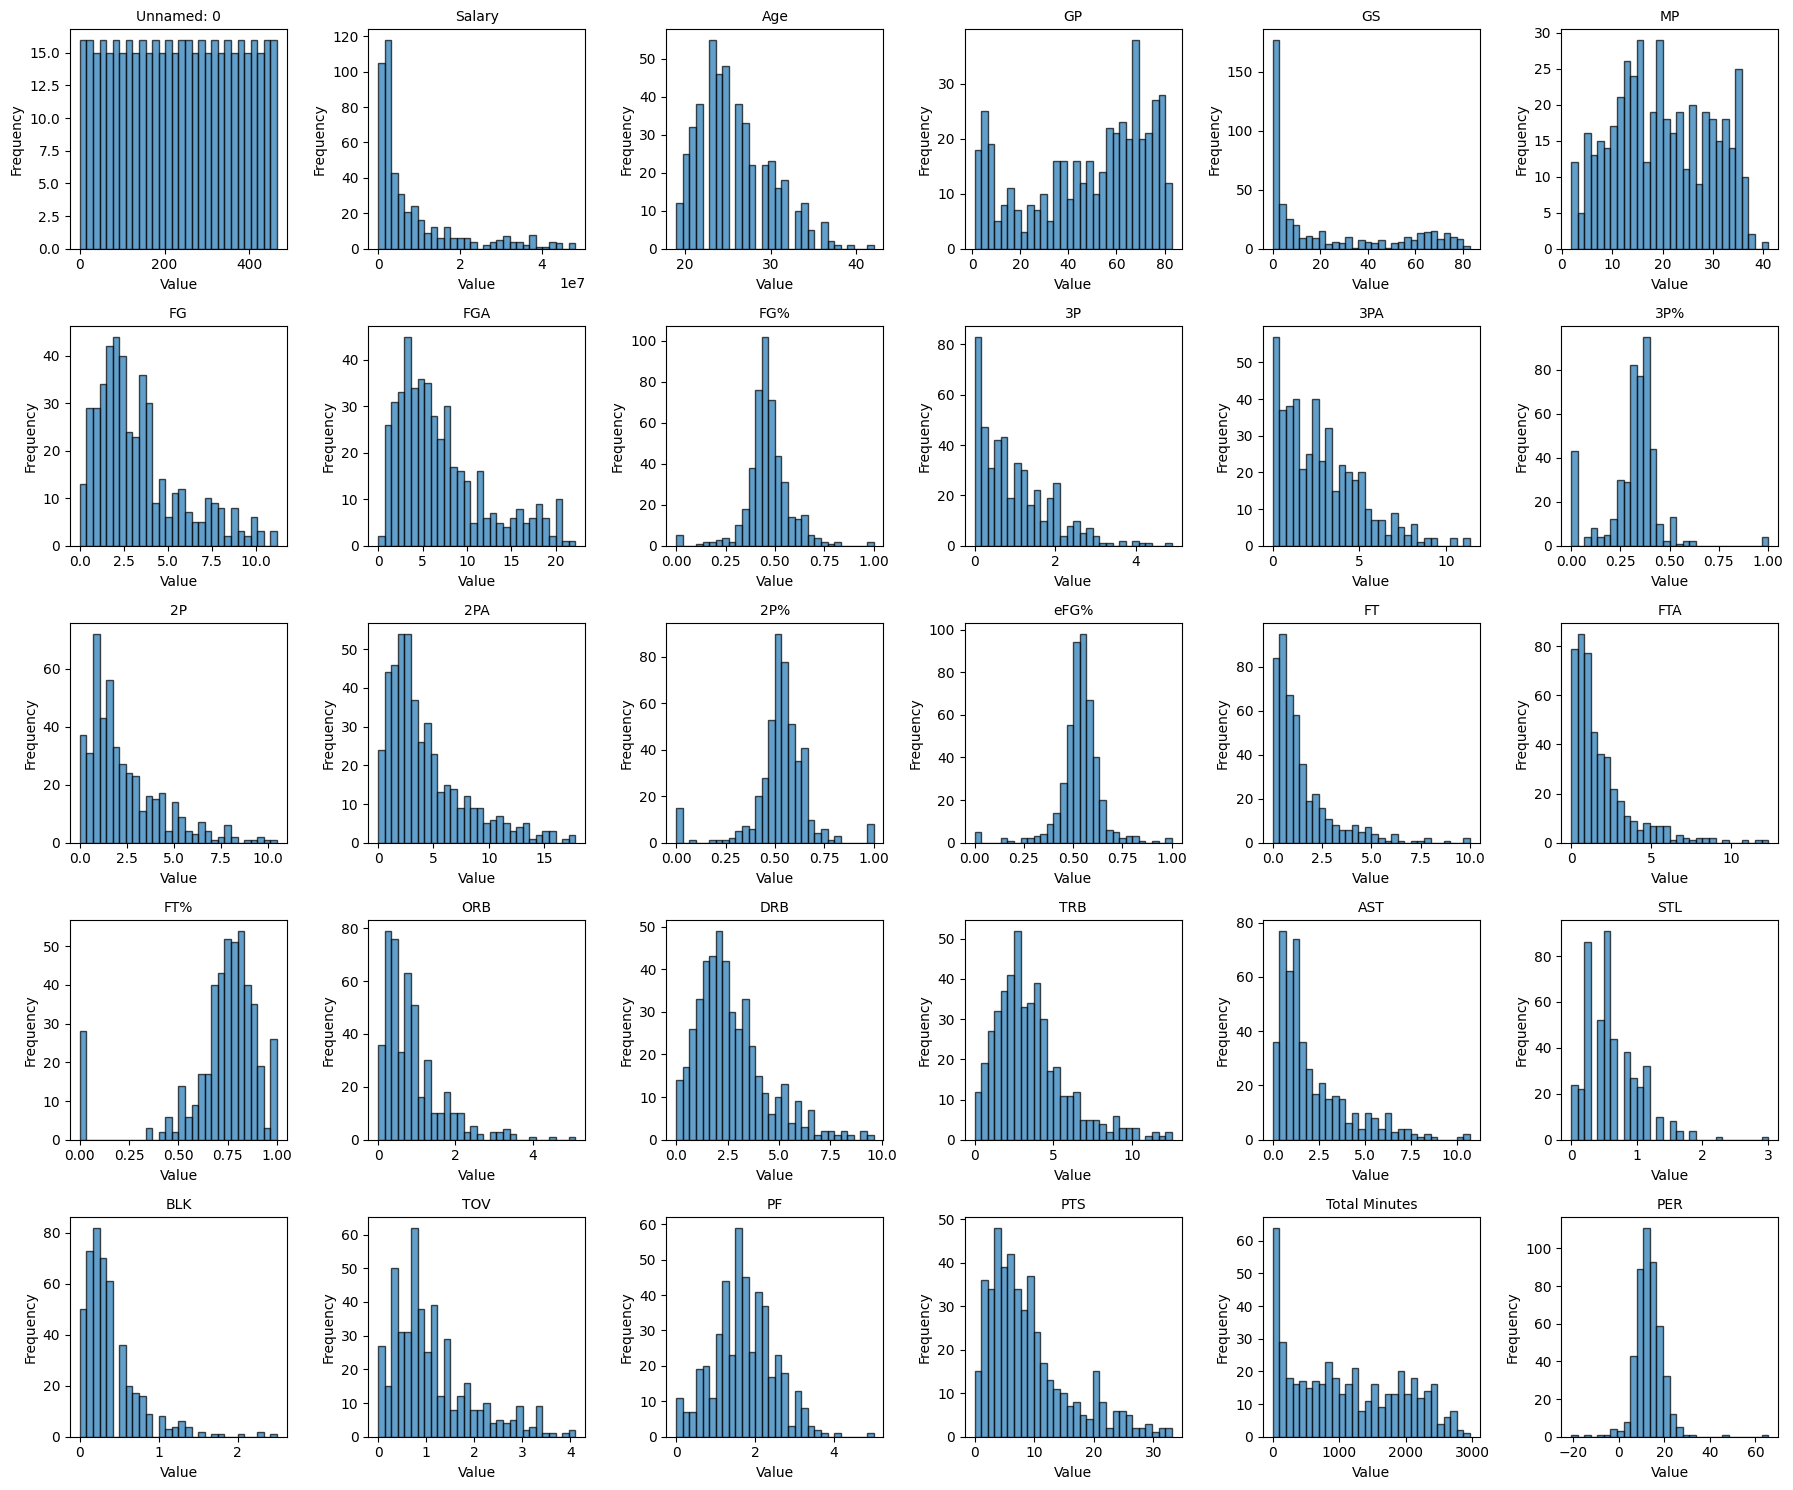

In [638]:
numericCols = dfCleaned.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(5, 6, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(numericCols[:30]):  # Show first 30 numeric columns
    axes[idx].hist(dfCleaned[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(col, fontsize=10)
    axes[idx].set_xlabel('Value')
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Drop closely related columns?

In [639]:
# # Select numeric columns
# numeric_df = dfCleaned.select_dtypes(include=[float, int])

# # Compute absolute correlation matrix
# corr_matrix = numeric_df.corr().abs()

# # Set threshold
# threshold = 0.95

# # Create a set to hold columns to drop
# cols_to_drop = set()

# # Iterate over correlation matrix
# for i in range(len(corr_matrix.columns)):
#     for j in range(i+1, len(corr_matrix.columns)):
#         if corr_matrix.iloc[i, j] > threshold:
#             # Add one of the two columns to drop
#             cols_to_drop.add(corr_matrix.columns[j])

# # Drop the columns from the dataframe
# numeric_df_reduced = numeric_df.drop(columns=cols_to_drop)

# print(f"Columns dropped due to high correlation (> {threshold}): {cols_to_drop}")
# print(f"Remaining columns: {numeric_df_reduced.columns.tolist()}")
# non_numeric_cols = dfCleaned.select_dtypes(exclude=[float, int])
# dfCleaned = pd.concat([non_numeric_cols, numeric_df_reduced], axis=1)


In [640]:
# Drop non-numeric or identifier columns that aren’t useful for dimensionality reduction
dropCols = ["Player Name", "Team", "Position"]
dfNumeric = dfCleaned.drop(columns=dropCols, errors="ignore")

# Standardize numeric features
scaler = StandardScaler()
xScaled = scaler.fit_transform(dfNumeric)
xTrain, xTest = train_test_split(xScaled, test_size=0.2, random_state=42)

Question 1a

Autoencoder model

In [641]:
inputDimension = xTrain.shape[1]
encodingDimension = 2

inputDimension = xTrain.shape[1]
encodingDimension = 2

#Regularisation coefficients
lambda1 = 1e-5
lambda2 = 1e-4

encoder = models.Sequential([
    layers.Input(shape=(inputDimension,)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(encodingDimension)
])

decoder = models.Sequential([
    layers.Input(shape=(encodingDimension,)),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda2)),
    layers.Dense(64, activation='relu',
                 kernel_regularizer=regularizers.l2(lambda1)),
    layers.Dense(inputDimension, activation='linear')
])

autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(optimizer='adam', loss='mse')

Train Autoencoder

In [642]:
history = autoencoder.fit(
    xTrain, xTrain,
    epochs=50,
    batch_size=32,
    validation_data=(xTest, xTest),
    verbose=0
)

X_encoded = encoder.predict(xScaled)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


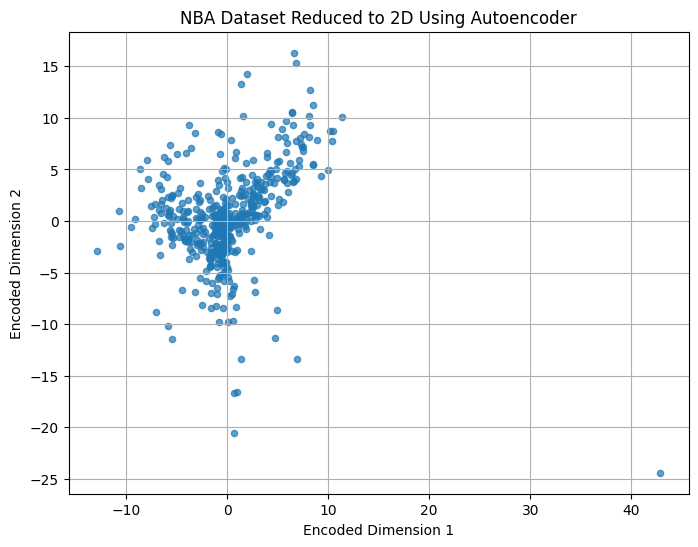

In [643]:
plt.figure(figsize=(8,6))
plt.scatter(X_encoded[:,0], X_encoded[:,1], s=20, alpha=0.7)
plt.title("NBA Dataset Reduced to 2D Using Autoencoder")
plt.xlabel("Encoded Dimension 1")
plt.ylabel("Encoded Dimension 2")
plt.grid(True)
plt.show()

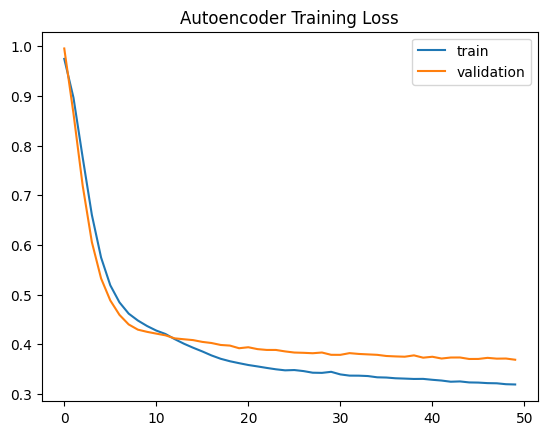

In [644]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Autoencoder Training Loss')
plt.show()


In [645]:
# Get reconstructed outputs
X_reconstructed = autoencoder.predict(xScaled)

# Compute Mean Squared Error (MSE) for each sample
reconstruction_errors = np.mean(np.square(xScaled - X_reconstructed), axis=1)

# Summary statistics
print("Mean reconstruction error:", np.mean(reconstruction_errors))
print("Std of reconstruction error:", np.std(reconstruction_errors))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean reconstruction error: 0.3225181570706603
Std of reconstruction error: 0.3375679869433177


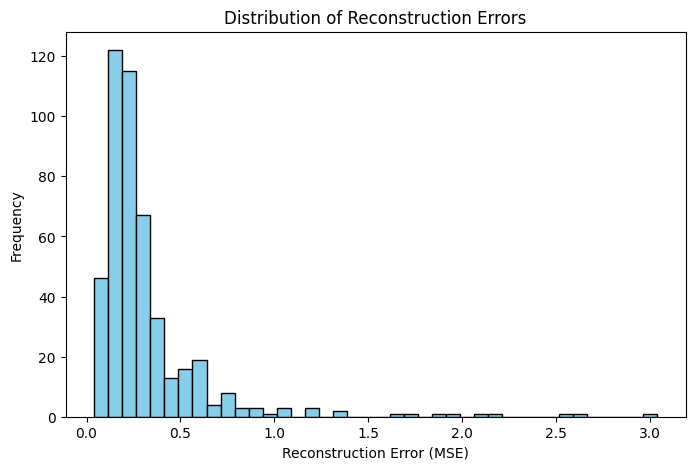

In [646]:
plt.figure(figsize=(8,5))
plt.hist(reconstruction_errors, bins=40, color='skyblue', edgecolor='k')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.show()


In [647]:
worst_idx = np.argsort(reconstruction_errors)[-5:]
df.iloc[worst_idx][["Player Name", "PTS", "Age", "Salary"]]


,Player Name,PTS,Age,Salary
466,Jacob Gilyard,3.0,24,5849
441,Braxton Key,1.3,25,201802
436,Alondes Williams,0.0,23,254446
439,Chris Silva,2.0,26,211045
458,Jordan Schakel,1.5,24,96514
